# Tests with the absorption Gaussian model

The GaussianAbsorption1D model in astropy is defined as (1. - Gaussian1D). This won't work when the independent variable is expressed in units such as $f_{\lambda}$, since the numerical values are very small (~ 1.E-15). Subtracting these values from 1. results in essentially an array of ones. 

Later in the work it was found that some of the fitters assume that the raw data to be fitted is previously normalized to be ~1. In such cases the existing GaussianAbsorption1D code should work most of the time. However, astropy doesn't have a mechanism to apply the normalization, and, most importantly, de-apply it after the model gets fitted.

The test below shows what happens when we use instead of GaussianAbsorption1D, just Gaussian1D with a negative amplitude, and keep the initialization code the same. The goal is to be able to compute sensible initial guesses for the parameters.

In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\mu$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.8, 2.4, 2.8e-15, 4.e-15]

<h3>Get raw data</h3>

This is the same dataset shown in github issue #145. 

In [2]:
data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]
indices = (wave > 0.475) & (wave < 0.497) 
w1 = wave[indices]
f1 = flux[indices]

<h3>Computing first guesses for the parameters</h3>

This is the same code used in other notebooks to compute initial guesses for the emission Gaussian.

In [3]:
from astropy.modeling import models

def initialize_gaussian(w, f):
    centroid = np.sum(w * f) / np.sum(f)

    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
    sigma = fwhm / 2.355

    delta_w = w[1:] - w[:-1]
    sum_f = np.sum((f[1:] - np.min(f[1:])) * delta_w)
    height = sum_f / (sigma * np.sqrt( 2 * np.pi))
    
    return height, centroid, sigma

def initialize_linear(w, f):
    # compute averages at the 5% of data at each extreme of the wavelength range.
    l = int(len(w) / 20)
    w1 = np.mean(w[0:l])
    w2 = np.mean(w[-l-1:-1])
    f1 = np.mean(f[0:l])
    f2 = np.mean(f[-l-1:-1])
    # fit a straigth line thru these 
    slope = (f2 - f1) / (w2 - w1)
    inter = f2 - slope * w2
    return slope, inter

def initialize_compound(w, f):
    slope, inter = initialize_linear(w, f)
    fc = f - (w * slope + inter)
    height, centroid, sigma = initialize_gaussian(w, fc)
    return height, centroid, sigma, slope, inter

Try two different approaches: 
 - compute initial guesses for the linear baseline, and for the gaussian itself, independently of each other;
 - compute all five initial guesses simultaneously.

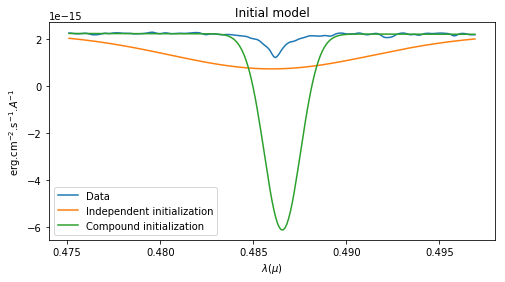

In [4]:
# independent Gaussian and linear initializations
h, c, s = initialize_gaussian(w1, f1)
# gaussian_s_1 = models.GaussianAbsorption1D(amplitude=h, mean=c, stddev=s)
gaussian_s_1 = models.Gaussian1D(amplitude=-h, mean=c, stddev=s)
s, i = initialize_linear(w1, f1)
linear_s_1 = models.Linear1D(slope=s, intercept=i)
model_s_1 = gaussian_s_1 + linear_s_1

# Gaussian + linear initialized all at once 
height, centroid, sigma, slope, inter = initialize_compound(w1, f1)
# gaussian_c_1 = models.GaussianAbsorption1D(amplitude=height, mean=centroid, stddev=sigma)
gaussian_c_1 = models.Gaussian1D(amplitude=-height, mean=centroid, stddev=sigma)
linear_c_1 = models.Linear1D(slope=slope, intercept=inter)
model_c_1 = gaussian_c_1 + linear_c_1

plot_axis = [0.47, 0.5, 1.e-15, 2.5e-15]
plt.gcf().set_size_inches(8.,4.)
plt.plot(w1, f1, label='Data')
plt.plot(w1, model_s_1(w1), label='Independent initialization')
plt.plot(w1, model_c_1(w1), label='Compound initialization')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Initial model")

The proposal for specviz is to replace the astropy version of absorption Gaussian with our own version, in which we will call the Gaussian1D model with negative amplitude. Thus it will share the common initialization code with the other emission line types. 

Or we could write our own absorption Gaussian, parametrized by optical depth or equivalent width.

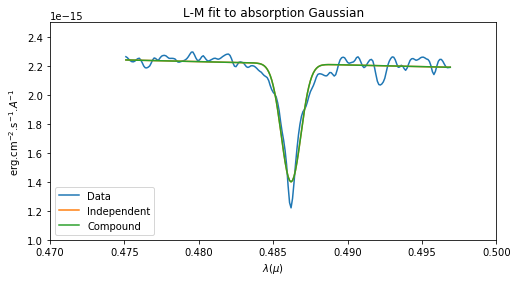

In [5]:
# Fit absorption Gaussian as defined above

from astropy.modeling import fitting

lm_fitter = fitting.LevMarLSQFitter()
lm_fm_s_1 = lm_fitter(model_s_1, w1, f1, maxiter=2000)
lm_fm_c_1 = lm_fitter(model_c_1, w1, f1, maxiter=2000)

plt.gcf().set_size_inches(8.,4.)
plt.plot(w1, f1, label='Data')
plt.plot(w1, lm_fm_s_1(w1), label='Independent')
plt.plot(w1, lm_fm_c_1(w1), label='Compound')
plt.axis(plot_axis)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("L-M fit to absorption Gaussian")

Even though this worked well, I found that the independent initialization doesn't work so well under specviz, even with similar data.

Lets try to work out a better initialization for the absorption Gaussian, in the lines of having a sort of linear+gaussian compound under the hood.


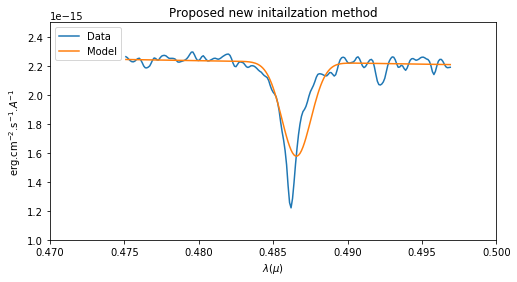

In [6]:
def initialize_gaussian_absorption(w, f):
    
    # start by computing an approximate linear continuum
    s, i = initialize_linear(w, f)

    # centroid is computed by subtracting this continuum 
    # estimate and then using it in the same way that is
    # used for computing the centroid of the emission Gaussian. 
    c = models.Linear1D(slope=slope, intercept=i)(w)
    f_s = f - c
    centroid = np.sum(w * f_s) / np.sum(f_s)

    # sigma is computed in the same way as with the emission 
    # Gaussian, but again using the continuum-subtracted data. 
    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f_s) / np.sum(f_s))
    sigma = fwhm / 2.355

    # amplitude is estimated from the difference in areas under the
    # (interpolated) linear continumm and the actual data.
    delta_w = w[1:] - w[:-1]
    sum_c = np.sum(c[1:] * delta_w)
    sum_f = np.sum(f[1:] * delta_w)
    amplitude = (sum_f - sum_c) / (sigma * np.sqrt( 2 * np.pi))
    
    return amplitude, centroid, sigma

# note that the amplitude parameter 'h' is already negative
h, c, s = initialize_gaussian_absorption(w1, f1)
gaussian_s_1 = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
s, i = initialize_linear(w1, f1)
linear_s_1 = models.Linear1D(slope=s, intercept=i)
model_s_1 = gaussian_s_1 + linear_s_1

plot_axis = [0.47, 0.5, 1.e-15, 2.5e-15]
plt.gcf().set_size_inches(8.,4.)
plt.plot(w1, f1, label='Data')
plt.plot(w1, model_s_1(w1), label='Model')
plt.axis(plot_axis)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title("Proposed new initailzation method")

An absorption line only makes sense if there is a pre-existing continuum, so no wonder we get a much better initial guess when we explictly take into account the continuum, even in an approximate form.